In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-10-12 09:43:53--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2022-10-12 09:43:53 (8.48 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [7]:
words = open('names.txt', 'r').read().splitlines()

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
block_size = 3 #trigrams

def build_dataset(words):
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [23]:
g = torch.Generator().manual_seed(2147483647)
# C is used as embedding table, we index the 27 chars in C 
# and the moste fficent embedding will be lern by the net
# C[5] is the same as onehotencoding(5, 27)@C
C = torch.randn((27, 10), generator=g)
# W1 dim is 30 because we embed 3 char each time in 10 dims so 3*10
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [25]:
#exp decay for lr
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [49]:
lri = []
lossi = []
stepi = []

for i in range(200000):
  
  #minibatch construct
  # matrix of shape [32] with rand int in range 0-Xtr.shape[0]
  ix = torch.randint(0, Xtr.shape[0], (32,))

  #forward
  # first indexing select 32 rows of Xtr giving a list of shape [32, 3]
  # second indexing select 32 rows of the C matrix giving shape [32, 3, 10]
  emb = C[Xtr[ix]] #[32,3,10]
  h = torch.tanh(emb.view(-1,30) @ W1 + b1) #[32, 200]
  logits = h @ W2 + b2 # [32, 27]
  # creates logits normalizing the exp than select the prob of predicting 
  # the right letter according e with Y the appli minus log mean
  loss = F.cross_entropy(logits, Ytr[ix])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())


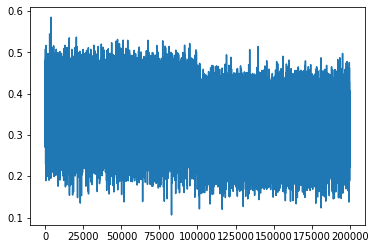

In [50]:
plt.plot(stepi, lossi)

In [51]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1019, grad_fn=<NllLossBackward0>)

In [52]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1549, grad_fn=<NllLossBackward0>)

In [53]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1608, grad_fn=<NllLossBackward0>)

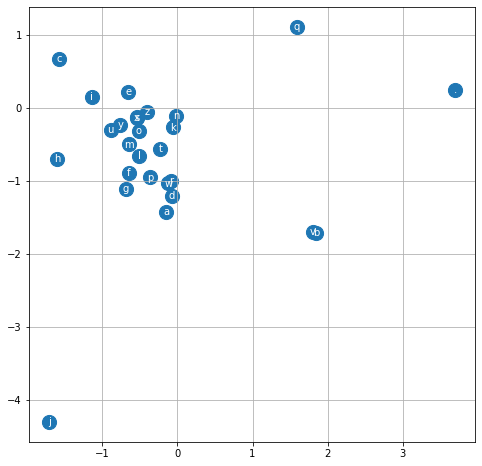

In [54]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,2].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [59]:
# sampling
#g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(10):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
    
  print(''.join(itos[i] for i in out))

legg.
halm.
join.
quinthsson.
malian.
quinterra.
jarynn.
jaxen.
iveah.
edde.


one way to find a good LR is by looking at the loss. We chose a lower bound (when optimization is extremely slow) and an upper one (whe is to fast and doesn't optimize at all).
Than we create an exp decay for LR and train the net then we plot
plt.plot(lri, lossi) and we look for the min which will be th eptimal LR 

Exercises:
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [71]:
t = torch.tensor([1./27])
loss = -(torch.ones((27,))*(t.exp()/(27.*t.exp()))).log().mean()
loss

tensor(3.2958)

In [69]:
from math
math.log(27)

3.295836866004329